In [1]:
!kaggle datasets download -d sshikamaru/car-object-detection

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection
License(s): other
 92% 103M/112M [00:01<00:00, 112MB/s] 
100% 112M/112M [00:01<00:00, 104MB/s]


In [2]:
!unzip -q '/content/car-object-detection.zip' -d '/content'

In [3]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

from utils import plot_image_with_bbox, convert_to_yolo_format, copy_images

In [4]:
# Step 2: Load Dataset
# Modify these paths to where your images and CSV file are located
original_train_image_dir = "/content/data/training_images"
test_image_dir = "/content/data/testing_images"
csv_file = "/content/data/train_solution_bounding_boxes (1).csv"

final_dir = '/content/yolo_dataset'
train_dir = os.path.join(final_dir, 'train')
train_img_dir = os.path.join(train_dir, 'images')
train_label_dir = os.path.join(train_dir, 'labels')
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)

val_dir = os.path.join(final_dir, 'val')
val_img_dir = os.path.join(val_dir, 'images')
val_label_dir = os.path.join(val_dir, 'labels')
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# Step 3: Read the CSV file
df = pd.read_csv(csv_file)
print(df.head())

# Step 4: Check for any missing data
print("Missing values in the dataset:")
print(df.isnull().sum())

# Step 5: Basic dataset information
print(f"Total training images: {len(df['image'].unique())}")
print(f"Bounding box records: {len(df)}")

             image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
Missing values in the dataset:
image    0
xmin     0
ymin     0
xmax     0
ymax     0
dtype: int64
Total training images: 355
Bounding box records: 559


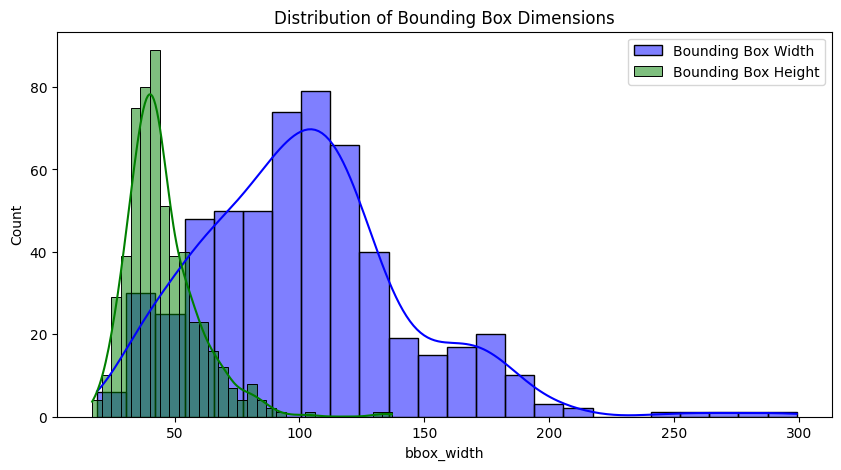

In [5]:
# Step 6: Visualize the bounding box distribution (width and height of boxes)
df['bbox_width'] = df['xmax'].astype(float).astype(int) - df['xmin'].astype(float).astype(int)
df['bbox_height'] = df['ymax'].astype(float).astype(int) - df['ymin'].astype(float).astype(int)

plt.figure(figsize=(10, 5))
sns.histplot(df['bbox_width'], color='blue', label='Bounding Box Width', kde=True)
sns.histplot(df['bbox_height'], color='green', label='Bounding Box Height', kde=True)
plt.legend()
plt.title('Distribution of Bounding Box Dimensions')
plt.show()

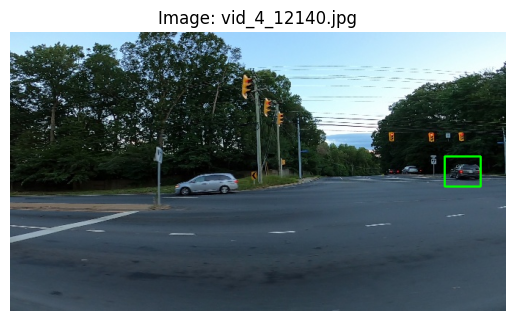

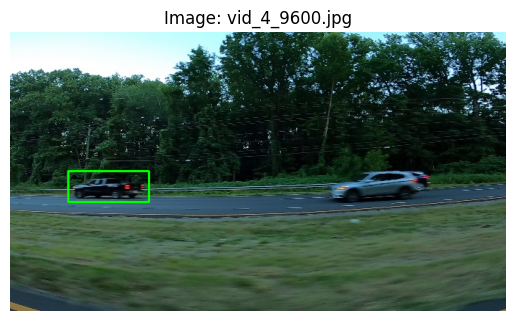

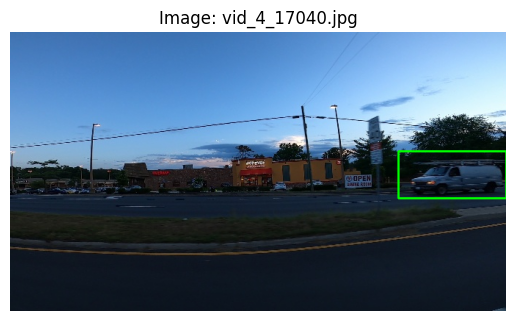

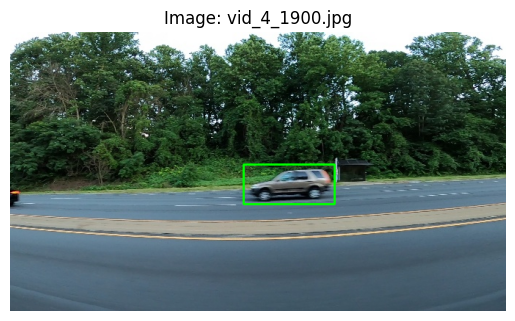

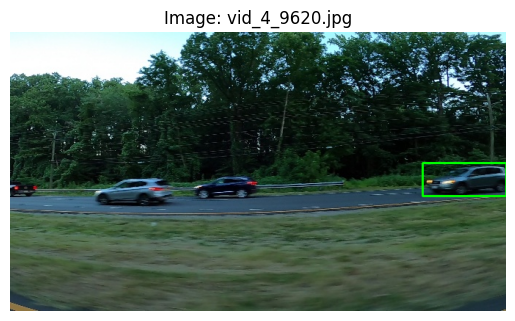

Training samples: 447
Validation samples: 112
Data Preparation and EDA Complete


In [6]:
# Step 8: Plot a few random samples
sample_images = df.sample(5)
for idx, row in sample_images.iterrows():
    plot_image_with_bbox(original_train_image_dir, row['image'], [row['xmin'], row['ymin'], row['xmax'], row['ymax']])

# Step 9: Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Save train and validation split to CSV files for later use
train_csv_path = '/content/train_split.csv'
val_csv_path = '/content/val_split.csv'

train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)

copy_images(train_csv_path, original_train_image_dir, train_img_dir)
copy_images(val_csv_path, original_train_image_dir, val_img_dir)

convert_to_yolo_format(train_csv_path, train_label_dir, train_img_dir)
convert_to_yolo_format(val_csv_path, val_label_dir, val_img_dir)

print("Data Preparation and EDA Complete")

# Model part

In [7]:
# Step 1: Import Libraries
import torch
from matplotlib import pyplot as plt
import cv2
import os
from glob import glob
import pandas as pd
from pathlib import Path
import numpy as np
from IPython.display import Image  # For displaying images in the notebook

# Step 2: Set up paths and variables
root_dir = "/content/yolo_dataset/"
train_image_dir = "/content/yolo_dataset/train"
val_image_dir = "/content/yolo_dataset/val"


# Step 5: Dynamically create dataset YAML file (code above)
dataset_name = 'car_detection_project'
num_classes = 1
class_names = ['car']

# Creating the YAML file dynamically
dataset_config = {
    'path': root_dir,
    'train': train_image_dir,
    'val': val_image_dir,
    'nc': num_classes,
    'names': class_names
}

yaml_file_path = f'/content/{dataset_name}.yaml'

import yaml
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(dataset_config, yaml_file, default_flow_style=False)


# Step 3: Install YOLOv5 if not already installed
!git clone https://github.com/ultralytics/yolov5  # Clone the YOLOv5 repo
%cd yolov5
!pip install -r requirements.txt  # Install dependencies

from ultralytics import YOLO
# Step 6: Train YOLOv5 model
model = YOLO('yolov8n.pt')

# Disable W&B logging to avoid the API key prompt
os.environ["WANDB_MODE"] = "disabled"
results = model.train(
    data=yaml_file_path,
    epochs=100,
    imgsz=640,
    batch=16,
    name='car_detection_model'
)

Cloning into 'yolov5'...
remote: Enumerating objects: 16965, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 16965 (delta 82), reused 103 (delta 50), pack-reused 16805 (from 1)
Receiving objects: 100% (16965/16965), 15.71 MiB | 14.49 MiB/s, done.
Resolving deltas: 100% (11620/11620), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.8/874.8 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 122MB/s]


Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/car_detection_project.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=car_detection_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

100%|██████████| 755k/755k [00:00<00:00, 27.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/yolo_dataset/train/labels... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 1919.21it/s]

train: New cache created: /content/yolo_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolo_dataset/val/labels... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<00:00, 1367.62it/s]

val: New cache created: /content/yolo_dataset/val/labels.cache


Plotting labels to runs/detect/car_detection_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/car_detection_model
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.22G      1.517      3.092       1.16          6        640: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         94         94    0.00333          1      0.509      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.17G       1.32      1.913      1.104          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         94         94     0.0033      0.989      0.241     0.0868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.18G      1.363      1.853      1.118          2        640: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         94         94      0.716     0.0213      0.324      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.18G      1.293      1.711      1.085          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         94         94      0.571      0.638      0.543      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.18G      1.311      1.606      1.105          9        640: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         94         94      0.558      0.798      0.575      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.18G      1.331       1.49      1.107          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


                   all         94         94      0.518      0.638      0.553      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.18G      1.257      1.401      1.084          7        640: 100%|██████████| 20/20 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all         94         94      0.542      0.592      0.487      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.18G       1.24      1.317      1.092          8        640: 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


                   all         94         94      0.493      0.754      0.566      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.18G      1.211      1.286      1.043          7        640: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         94         94      0.564      0.585      0.563      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.18G       1.21      1.212      1.043          2        640: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


                   all         94         94      0.523      0.818       0.63      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.18G      1.255      1.185      1.093          9        640: 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

                   all         94         94      0.551      0.766       0.64      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.18G      1.241      1.126      1.066          7        640: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         94         94      0.653      0.745      0.647      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.18G      1.174      1.061      1.062          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


                   all         94         94      0.471       0.83      0.562      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.18G      1.167      1.052      1.058          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         94         94      0.534      0.862      0.631      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.18G      1.198       1.04      1.048          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         94         94      0.557      0.789      0.676      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.18G      1.234      1.028      1.072          7        640: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         94         94      0.597      0.745      0.696      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.18G      1.177      1.007      1.068          6        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         94         94      0.563      0.862      0.704      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.18G      1.171     0.9859      1.055          2        640: 100%|██████████| 20/20 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

                   all         94         94       0.55      0.885      0.661       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.18G      1.163          1      1.049          5        640: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         94         94      0.619      0.809      0.673       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.18G      1.236     0.9971      1.094          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         94         94      0.563      0.904      0.654      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.18G      1.185     0.9338      1.041          6        640: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         94         94      0.558      0.787      0.648      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.18G      1.136      0.917      1.051          4        640: 100%|██████████| 20/20 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         94         94      0.586      0.809      0.654      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.18G      1.112     0.8692      1.028          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         94         94      0.595      0.809      0.643      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.18G      1.124     0.8876      1.037          6        640: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


                   all         94         94      0.549      0.872      0.672      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.18G      1.062     0.8579      1.017          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         94         94      0.544      0.787      0.645      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.18G       1.12     0.9071      1.024          8        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         94         94      0.545      0.809      0.684      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.18G      1.088     0.8384      1.029          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

                   all         94         94      0.452      0.777      0.628      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.18G      1.129     0.8657      1.046          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         94         94      0.504      0.968      0.651      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.18G      1.115     0.9008      1.039          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         94         94      0.544      0.819      0.679      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.18G      1.112      0.882      1.037          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         94         94      0.544       0.83      0.655      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.18G      1.091     0.8695      1.031          7        640: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         94         94      0.564       0.83      0.671      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.18G      1.088     0.9042      1.023          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         94         94      0.619      0.641       0.68      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.18G      1.068     0.8615      1.035          7        640: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         94         94      0.557      0.801      0.682      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.18G      1.061     0.8063       1.02          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         94         94      0.528      0.926      0.692       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.18G      1.042     0.7805      1.003          4        640: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         94         94      0.533      0.787      0.645      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.18G      1.024     0.8484     0.9994          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         94         94      0.498      0.851      0.642      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.18G      1.091     0.8728       1.03          8        640: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         94         94      0.492      0.904      0.665      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.18G       1.02     0.8228      1.005          6        640: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

                   all         94         94      0.488      0.941      0.666      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.18G      1.049     0.8151      1.013          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

                   all         94         94      0.482      0.915      0.626      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.18G      1.026     0.7983      1.008          9        640: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         94         94       0.52        0.9      0.644      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.18G      1.056     0.8121     0.9989          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         94         94      0.496      0.894      0.608       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.18G      1.045     0.7875      1.008          7        640: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all         94         94      0.474      0.904      0.637      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.18G      1.045     0.8018     0.9985          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

                   all         94         94      0.528       0.84      0.654      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.18G      1.068     0.7985      1.015          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         94         94      0.509      0.968      0.619      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.18G     0.9919     0.7687     0.9944         10        640: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

                   all         94         94      0.515      0.862      0.677      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.18G     0.9686     0.7611     0.9741          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         94         94      0.503      0.915      0.655      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.18G     0.9892       0.75      0.978          6        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         94         94      0.531      0.904      0.617      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.18G       1.05     0.8885      1.017          1        640: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         94         94      0.502      0.851      0.638      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.18G      1.001     0.7229     0.9971          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         94         94      0.508      0.926      0.611      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.18G     0.9996     0.7105      0.993          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

                   all         94         94      0.495      0.814      0.611      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.18G     0.9567     0.7309      0.974          7        640: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         94         94      0.493       0.84      0.584       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.18G     0.9337     0.7331     0.9779          7        640: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

                   all         94         94      0.497      0.862      0.604       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.18G     0.9909     0.7364      0.982          8        640: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         94         94      0.526       0.83      0.641      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.18G     0.9661     0.7096      0.972          5        640: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         94         94      0.512      0.819      0.634      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.18G     0.9654     0.7042     0.9656          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

                   all         94         94      0.515      0.723      0.609      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.18G     0.9793     0.6897      0.985          7        640: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         94         94      0.486      0.915      0.574      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.18G     0.9605     0.6964     0.9807          5        640: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         94         94      0.482      0.915      0.623      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.18G     0.9689     0.6852     0.9733          7        640: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

                   all         94         94      0.502       0.75       0.61      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.18G     0.9409       0.71     0.9517          7        640: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         94         94      0.491       0.83      0.574      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.18G     0.9598     0.7033     0.9724          7        640: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         94         94      0.472      0.723      0.534      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.18G     0.9181     0.6589     0.9723          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         94         94      0.492      0.833       0.55      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.18G     0.9247     0.6535      0.966          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         94         94      0.487      0.702      0.538      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.18G      0.939     0.6523     0.9682          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         94         94      0.472      0.742      0.503      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.18G     0.9063      0.686     0.9592          8        640: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         94         94      0.467       0.83      0.574      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.18G     0.9154     0.6616     0.9624          6        640: 100%|██████████| 20/20 [00:04<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

                   all         94         94      0.424      0.791      0.555      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.18G     0.9049     0.6481     0.9431          5        640: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         94         94      0.415      0.657      0.529      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.18G     0.8894     0.6164     0.9351          7        640: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


                   all         94         94      0.441      0.713      0.548      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.18G      0.874     0.6396     0.9463          9        640: 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         94         94      0.454      0.708      0.555      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.18G     0.8758     0.6133     0.9559          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         94         94      0.472      0.723      0.555      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.18G      0.893      0.613     0.9525          4        640: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

                   all         94         94        0.5      0.701      0.568      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.18G     0.8996     0.6338     0.9422          6        640: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         94         94      0.521      0.638      0.543      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.18G      0.876     0.6306      0.949          8        640: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         94         94      0.474      0.745      0.565      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.18G     0.8676     0.5994      0.949          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         94         94      0.425      0.862      0.563      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.18G     0.8656     0.5916     0.9369          6        640: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         94         94      0.466      0.641      0.561      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.18G     0.8359     0.5725     0.9247         10        640: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         94         94      0.455      0.628      0.492      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.18G     0.8254     0.5609     0.9334          6        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

                   all         94         94      0.457      0.644      0.479      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.18G     0.8225     0.5955     0.9354          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


                   all         94         94      0.463      0.649      0.479      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.18G     0.8291       0.58     0.9419          4        640: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         94         94      0.445      0.638      0.516      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.18G     0.8569      0.575     0.9468         10        640: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]

                   all         94         94      0.455       0.66       0.53      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.18G     0.8012     0.5557     0.9266          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         94         94       0.48      0.638      0.467      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.18G     0.7982     0.5544     0.9299          6        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

                   all         94         94      0.446      0.681      0.451      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.18G     0.7847     0.5583      0.938          3        640: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all         94         94      0.442      0.617      0.489      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.18G     0.8019     0.5615     0.9344          6        640: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         94         94      0.429      0.649      0.497      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.18G     0.8223     0.5328     0.9354          5        640: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         94         94      0.348      0.915      0.506      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.18G     0.7748     0.5495     0.9162          5        640: 100%|██████████| 20/20 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         94         94      0.455      0.675      0.513      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.18G     0.8103      0.547     0.9154          6        640: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

                   all         94         94      0.433      0.657      0.487      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.18G     0.7791      0.535     0.9059          7        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

                   all         94         94       0.46      0.702      0.482      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.18G     0.7778     0.5306     0.9225          8        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         94         94      0.448      0.564      0.419      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.18G     0.7947     0.5376     0.9053          9        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

                   all         94         94      0.466      0.638      0.435      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.18G     0.7638     0.5168     0.9093          8        640: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         94         94      0.463       0.66      0.463      0.318


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.18G     0.8033     0.5204     0.9183          3        640: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

                   all         94         94       0.46       0.58      0.426      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.18G     0.7691     0.4942     0.9184          3        640: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         94         94      0.463      0.553      0.399      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.18G     0.7413     0.4667     0.9033          3        640: 100%|██████████| 20/20 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

                   all         94         94      0.454      0.617      0.408      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.18G     0.7435     0.4685     0.9125          3        640: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         94         94      0.438      0.563      0.401      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.18G     0.7444     0.4674       0.89          3        640: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         94         94      0.449      0.553       0.39      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.18G     0.7373     0.4534     0.9065          3        640: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


                   all         94         94      0.443      0.543      0.383      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.18G     0.7105      0.451     0.9107          3        640: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         94         94      0.452      0.574      0.395      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.18G     0.7295     0.4499     0.9088          3        640: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         94         94      0.452      0.543      0.392      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.18G     0.7091     0.4432     0.9021          3        640: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         94         94       0.46      0.553      0.409      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.18G     0.6996     0.4393     0.9134          3        640: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

                   all         94         94      0.458      0.553      0.411       0.28



100 epochs completed in 0.212 hours.
Optimizer stripped from runs/detect/car_detection_model/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/car_detection_model/weights/best.pt, 6.2MB

Validating runs/detect/car_detection_model/weights/best.pt...
Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


                   all         94         94      0.528      0.926      0.691       0.46
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/car_detection_model


In [8]:
results = model.val()

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/yolo_dataset/val/labels.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


                   all         94         94      0.526      0.926      0.689      0.458
Speed: 0.3ms preprocess, 6.1ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs/detect/car_detection_model2


In [9]:
# Step 7: Inference on validation images
# After training, you can perform inference on your validation set to visualize predictions
# Step 8: Plotting results
# The detect.py script saves predictions in runs/detect/exp directory
detected_images = glob('/content/yolov5/runs/detect/car_detection_model5/*.jpg')

for image_path in detected_images:
    display(Image(filename=image_path))